In [1]:
# This cell allows the jupyter notebook to take up the space of your full web browser.

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import galXgam
from galXgam.utils import get_rms
from galXgam.utils import gal2equat
from galXgam.utils import catalogue_to_map
from galXgam.utils import map_to_array_of_indices_including_repeats
from galXgam.utils import map_to_catalogue_in_equatorial_coordinates
from galXgam.utils import overdensity_to_mean_counts
from galXgam.utils import sample_galaxy_overdensity_map
from galXgam.utils import overdensity_map_to_density_map
from galXgam.utils import overdensity_map_to_density_map_but_keep_negative_values
from galXgam.utils import overdensity_map_to_density_map_but_keep_negative_values_and_use_rms
from galXgam.utils import read_galaxy_catalogue
from galXgam.utils import read_galaxy_mask
from galXgam.utils import read_and_mask_gamma_ray_map
from galXgam.utils import get_gamma_ray_flux_per_unmasked_pixel
from galXgam.utils import get_gamma_ray_rms_of_unmasked_pixels
from galXgam.utils import compute_treecorr_catalogue_and_pair_counts
from galXgam.utils import compute_xi_and_r_from_treecorr_objects
from galXgam.utils import compute_xi_and_r_from_catalogue_and_random_catalogue
from galXgam.utils import get_random_catalogue_in_equatorial_coordinates_across_an_unmasked_sphere
from galXgam.utils import get_random_catalogue_in_equatorial_coordinates_for_binary_mask
from galXgam.utils import transform_C_ell_to_xi

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
from scipy import interpolate
import treecorr as tr
import numpy as np
import healpy as hp
# import astrotools.healpytools as hpt
import pandas as pd
# import fitsio
# from astropy.io import fits
# import fileinput
import copy
# import camb
# from camb import correlations
# import collections as clt
# import warnings
np.random.seed(12345)

# Enter Directories Here:

In [5]:
galaxy_catalogue_directory = "/nfs/slac/kipac/fs1/g/des/aresh/Gamma_Ray_x_DES/redMaGiC_Maps_from_redmine"

galaxy_mask_directory = "/nfs/slac/kipac/fs1/g/des/aresh/Gamma_Ray_x_DES/redMaGiC_Maps_from_redmine"

galaxy_overdensity_map_directory = "/nfs/slac/kipac/fs1/g/des/aresh/Gamma_Ray_x_DES/notebook_scripts_and_outputs/using_raw_data/cross/for_all_z_and_E_bins_new_foreground_subtraction/flask_directory/stefano_cls/flaskpipe/output_old_C_ells/sdss_12345"

C_ell_directory = "/nfs/slac/kipac/fs1/g/des/aresh/Gamma_Ray_x_DES/notebook_scripts_and_outputs/using_raw_data/cross/for_all_z_and_E_bins_new_foreground_subtraction/flask_directory/stefano_cls/flaskpipe/output_old_C_ells/sdss_12345"

flaskpipe_directory = "/nfs/slac/kipac/fs1/g/des/aresh/Gamma_Ray_x_DES/notebook_scripts_and_outputs/using_raw_data/cross/for_all_z_and_E_bins_new_foreground_subtraction/flask_directory/stefano_cls/flaskpipe"

# Enter Filenames Here:

In [6]:
galaxy_catalogue_filename = galaxy_catalogue_directory + "/5bins_hidens_hilum_higherlum_jointmask_0.15-0.9_magauto_mof_combo_removedupes_spt_fwhmi_exptimei_cut_badpix_sample_weighted2sig.fits"

galaxy_mask_filename = galaxy_mask_directory + "/5bins_hidens_hilum_higherlum_jointmask_0.15-0.9_magauto_mof_combo_removedupes_spt_fwhmi_exptimei_cut_badpix_mask.fits"

galaxy_overdensity_map_filename = galaxy_overdensity_map_directory + "/map-f3z3.fits"

C_ell_galaxy_filename = C_ell_directory + "/sdssCl-f3z3f3z3.dat"

# Masked Sampling from Flask Maps

In [7]:
nside=1024
nside_for_galaxy_mask_map=4096

In [8]:
true_ras, true_decs, true_weights = read_galaxy_catalogue(galaxy_catalogue_filename, 0.50, 0.65)

In [9]:
RM_galaxy_mask_map, number_of_galaxies_per_unmasked_pixel = read_galaxy_mask(galaxy_mask_filename, true_weights, nside, nside_for_galaxy_mask_map)
RM_galaxy_mask_map_low_res = np.around(hp.ud_grade(RM_galaxy_mask_map, nside))

sum_of_pixel_mask_values: 408545.3125
number_of_galaxies: 207867.40447864778
number_of_galaxies_per_unmasked_pixel: 0.5087988972548737


NSIDE = 1024
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


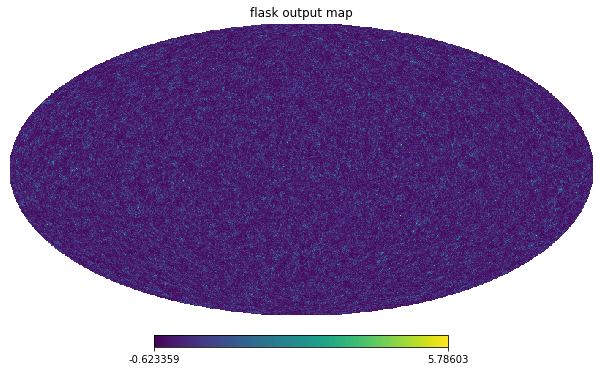

In [10]:
galaxy_overdensity_map = hp.read_map(galaxy_overdensity_map_filename)
sampled_galaxy_map = sample_galaxy_overdensity_map(galaxy_overdensity_map, number_of_galaxies_per_unmasked_pixel, nside)

# Get the input C_ells

In [11]:
C_ell_galaxy_filename = C_ell_directory + "/sdssCl-f3z3f3z3.dat"
a = pd.read_csv(C_ell_galaxy_filename, sep=" ",header=None)
semi_full_ell = a[0].values[0:1024]
semi_full_C_ell_original = a[1].values[0:1024]
ell = a[0].values[9:1024]
C_ell_original = a[1].values[9:1024]

# Comparing Input C_ells vs C_ells from Poisson-Sampled Simulated Galaxy Map

In [12]:
galaxy_alm_output = hp.map2alm(sampled_galaxy_map, lmax=1024)
C_ell_from_sampled_map = hp.alm2cl(galaxy_alm_output)[10:]

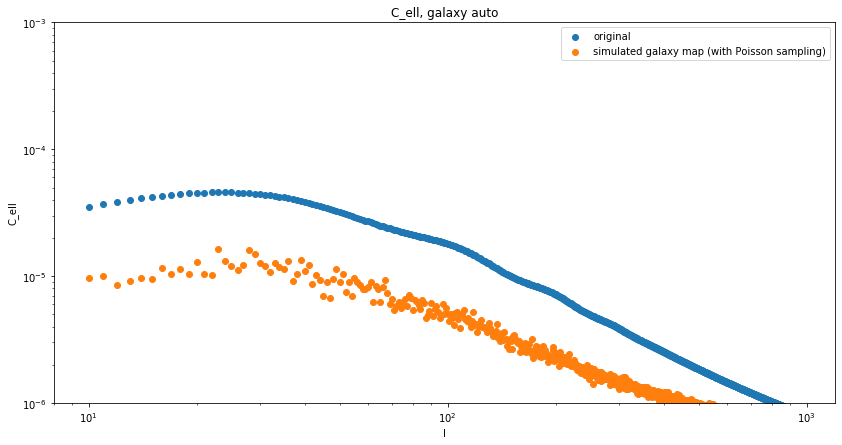

In [13]:
plt.figure(figsize=(14,7))
plt.scatter(ell, C_ell_original, label="original")
plt.scatter(ell, C_ell_from_sampled_map, label="simulated galaxy map (with Poisson sampling)")
plt.xscale("log")
plt.xlabel("l")
plt.ylabel("C_ell")
plt.xlim(8,1200)
plt.ylim(1E-6,1E-3)
plt.title("C_ell, galaxy auto")
plt.yscale("log")
plt.legend()

# Comparing Input C_ells vs C_ells Raw Overdensity Produced By FLASK

In [14]:
galaxy_alm_output = hp.map2alm(galaxy_overdensity_map, lmax=1024)
C_ell_from_flask_map = hp.alm2cl(galaxy_alm_output)[10:]

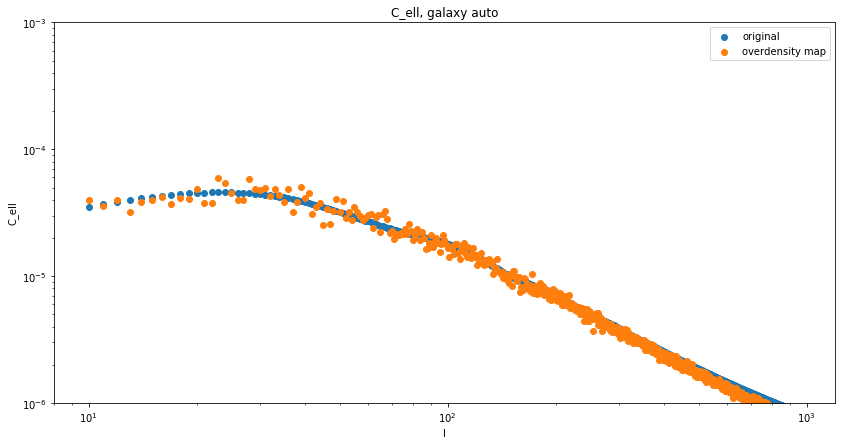

In [15]:
plt.figure(figsize=(14,7))
plt.scatter(ell, C_ell_original, label="original")
plt.scatter(ell, C_ell_from_flask_map, label="overdensity map")
plt.xscale("log")
plt.xlabel("l")
plt.ylabel("C_ell")
plt.xlim(8,1200)
plt.ylim(1E-6,1E-3)
plt.title("C_ell, galaxy auto")
plt.yscale("log")
plt.legend()

# Using Treecorr to get CF from Overdensity Map

In [16]:
rand_ras, rand_decs = get_random_catalogue_in_equatorial_coordinates_for_binary_mask("equatorial", RM_galaxy_mask_map, 9806760)

In [17]:
rand, rr = compute_treecorr_catalogue_and_pair_counts(rand_ras, rand_decs, np.ones_like(rand_ras))

In [18]:
o_cat_ras, o_cat_decs, o_cat_weights = map_to_catalogue_in_equatorial_coordinates(galaxy_overdensity_map * RM_galaxy_mask_map_low_res, "equatorial", True)

In [19]:
cat, dd = compute_treecorr_catalogue_and_pair_counts(o_cat_ras, o_cat_decs, o_cat_weights)

In [20]:
r = np.load(flaskpipe_directory + "/r.npy")

In [21]:
o_xi_final, r = compute_xi_and_r_from_treecorr_objects(cat, dd, rand, rr)

# Transforming input C_ells to a CF and comparing that to CF from the Simulated Galaxy Map, the Overdensity Map, and the Data (Which is a Galaxy Catalogue)

In [28]:
tck = interpolate.splrep(semi_full_ell, semi_full_C_ell_original)
a_1_final = interpolate.splev([0], tck)
new_ell = [0] + semi_full_ell.tolist()
new_C_ell_original = a_1_final.tolist() + semi_full_C_ell_original.tolist()

ell = np.array(new_ell[:1025])
C_ell_original = new_C_ell_original[:1025]

In [23]:
theta_arcmin = copy.deepcopy(r)
theta = np.array(theta_arcmin) / 60.0
theta_radian = np.radians(theta)
cosines = np.cos(theta_radian)

In [30]:
xi_fourier_from_C_ell_original = transform_C_ell_to_xi(C_ell_original, ell, cosines)

In [31]:
cat, dd = compute_treecorr_catalogue_and_pair_counts(true_ras, true_decs, true_weights)
xi_true, r_true = compute_xi_and_r_from_treecorr_objects(cat, dd, rand, rr)

In [32]:
xi_final = np.load(galaxy_overdensity_map_directory+"/xi_f3z3_f3z3.npy")

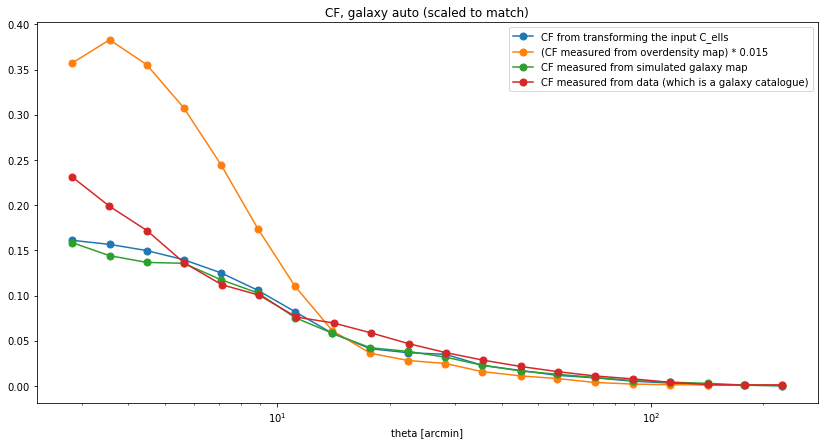

In [33]:
plt.figure(figsize=(14,7))
plt.plot(theta_arcmin, xi_fourier_from_C_ell_original, linestyle='-', marker='o', markersize=7, label = "CF from transforming the input C_ells")
plt.plot(r, xi_final, linestyle='-', marker='o', markersize=7, label = "CF measured from simulated galaxy map")
plt.xscale("log")
plt.xlabel("theta [arcmin]")
plt.title("CF, galaxy auto (scaled to match)")
plt.legend()